# Sellers Data Analysis

**Notebook Objective**

Since our analysis of the **Orders** dataset from Brazilian e-commerce platform **Olist** revealed that even though `wait_time` was one of the more significant factors in explaining `review_score`, the low R-squared in our regression model suggested that there were other factors to consider outside of the Orders data.

In this notebook we'll take a closer look at the **Sellers** dataset from **Olist** to see if there are elements associated with the `review_score`. In the first three sections, we'll do some exploratory data analysis by inspecting features, examine distributions, and then look for any correlation. Next, we'll apply linear and logistic regression models to better understand the relationship between specific features and seller `review_score`.

***Exploratory Data Analysis***

1. Inspect Features
2. Distributions
2. Correlations

***Models***

3. Multivariate Regression
4. Logistic Regression




If bad reviews are indeed linked to particular sellers, perhaps we'll be able to identify sellers who repeatedly perform poorly and try to understand why. 

We can then use this to respond to the CEO's request to improve Olist's customer satisfaction ratings and increase profit margins.

In [1]:
import os
os.sys.path

['/Users/atat/code/phlln/olist-analysis/notebooks',
 '/Users/atat/code/phlln/data-challenges/04-Decision-Science',
 '/Users/atat/code/phlln/olist-analysis/notebooks',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python38.zip',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python3.8',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python3.8/lib-dynload',
 '',
 '/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages',
 '/Users/atat/code/phlln/mlproject',
 '/Users/atat/code/phlln/TFM_TrainAtScale',
 '/Users/atat/code/phlln/TFM_PredictInProd',
 '/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/extensions',
 '/Users/atat/.ipython']

In [2]:
os.sys.path.insert(0, '/Users/atat/code/phlln/olist-analysis/' )

In [3]:
os.sys.path

['/Users/atat/code/phlln/olist-analysis/',
 '/Users/atat/code/phlln/olist-analysis/notebooks',
 '/Users/atat/code/phlln/data-challenges/04-Decision-Science',
 '/Users/atat/code/phlln/olist-analysis/notebooks',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python38.zip',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python3.8',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python3.8/lib-dynload',
 '',
 '/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages',
 '/Users/atat/code/phlln/mlproject',
 '/Users/atat/code/phlln/TFM_TrainAtScale',
 '/Users/atat/code/phlln/TFM_PredictInProd',
 '/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/extensions',
 '/Users/atat/.ipython']

In [4]:
# Import relevant libraries and modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import math

from olist.seller import Seller

## Inspect Features

In [5]:
# Load and inspect Seller Data
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,seller_review_score,review_cost_per_seller,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99


In [6]:
# Inspect data types and check for null values
sellers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2970 entries, 0 to 2969
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   seller_id               2970 non-null   object        
 1   seller_city             2970 non-null   object        
 2   seller_state            2970 non-null   object        
 3   delay_to_carrier        2970 non-null   float64       
 4   seller_wait_time        2970 non-null   float64       
 5   date_first_sale         2970 non-null   datetime64[ns]
 6   date_last_sale          2970 non-null   datetime64[ns]
 7   months_on_olist         2970 non-null   float64       
 8   share_of_one_stars      2970 non-null   float64       
 9   share_of_five_stars     2970 non-null   float64       
 10  seller_review_score     2970 non-null   float64       
 11  review_cost_per_seller  2970 non-null   int64         
 12  n_orders                2970 non-null   int64   

## Distributions

Let's begin by analyzing features from the **Sellers** dataset and understanding their distributions. We'll examine them in smaller groups:
- `delay_to_carrier`, `seller_wait_time`
- `n_orders`, `quantity`, `quantity_per_order`, `sales`, and `months_on_olist`
- `seller_review_score`, `share_of_one_stars`, and `share_of_five_stars`

### Distributions for `delay_to_carrier`, `seller_wait_time`

This pair of features relates to the time associated with order fulfillment and is calculated per seller.

- `delay_to_carrier` represents the average delay (in days) by a seller for delivering an order to the carrier. We can understand this as the delay to an order that is *attributable* to the seller.

- `seller_wait_time` represents the average `wait_time` (in days), starting from the customer placing an order online to receiving delivery of that order. 
(**Note:** This differs from the `wait_time` feature in the **Orders** dataset since it's been calculated as the average `wait_time` *for each seller*). 



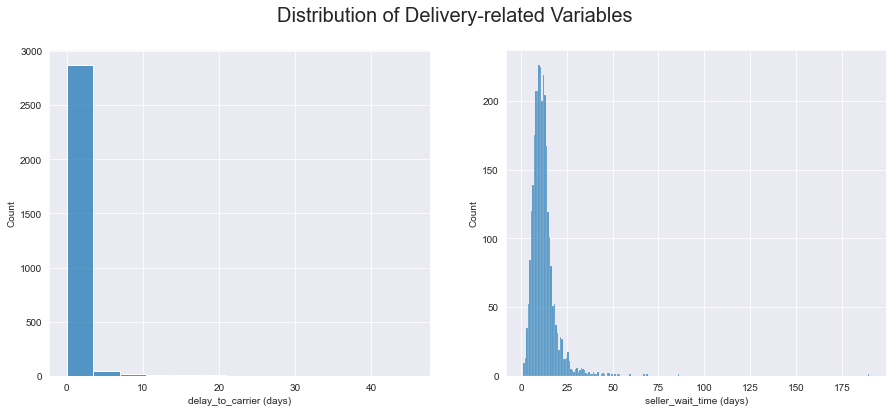

In [7]:
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1,2)
plt.figure(figsize=(15,6)).suptitle('Distribution of Delivery-related Variables', fontsize=20)
plt.close(1)

# 'delay_to_carrier' histogram
ax1 = plt.subplot(121)
ax1 = sns.histplot(sellers.delay_to_carrier)
plt.xlabel('delay_to_carrier (days)')

# 'seller_wait_time' histogram
ax2 = plt.subplot(122)
ax2 = sns.histplot(sellers.seller_wait_time)
plt.xlabel('seller_wait_time (days)')

plt.show(); 

There are some outliers here that skew the distribution plot, so let's also check out the summary stats. 

In [8]:
# Summary stats table
sellers[['delay_to_carrier','seller_wait_time']].describe()

,delay_to_carrier,seller_wait_time
count,2970.000000,2970.000000
mean,0.402786,12.160414
std,2.391687,7.103208
min,0.000000,1.214178
25%,0.000000,8.289263
50%,0.000000,11.120969
75%,0.000000,14.240673
max,45.434039,189.863160


We can see that delays in the order caused by the seller are actually not that common, so by itself the feature `delay_to_carrier` is not enough to provide a full enough explanation for low review scores.

While the plot for `seller_wait_time` is heavily right-skewed, this appears to be the effect of only a few outliers. We also see that the mean is still close to the median signaling that most sellers are clustered tightly around the center and the pull of outliers is not extreme. 

Additionally, we can confirm this by checking the **coefficient of variation** (std / mean). When the value is less than one, we have **low variance** (7.10 / 12.16 = **0.58**).

REMOVE BELOW?

In [9]:
# How many sellers contribute to delays?
num_sellers_delay = len((sellers[sellers['delay_to_carrier'] > 0]))
num_sellers_delay

243

In [10]:
#What percentage of sellers contribute to delays?
round(num_sellers_delay / len(sellers), 2) * 100

8.0

In [11]:
# What is the average review score for sellers that have delayed shipment to carriers?
sellers[sellers['delay_to_carrier'] > 0].seller_review_score.mean()


3.3051861527612707

In [12]:
#How does that compare to the review score of all sellers? 
sellers.seller_review_score.mean()

4.086880345061921

With sellers who have had delayed shipment to carriers, there is a 0.78 (4.09 - 3.31) decrease in avg. review score. Let's keep 'delay_to_carrier' as a feature to include in OLS Regression since it appears to have an impact on customer reviews.

Appears to be many new sellers on Olist platform. Include 'months_on_olist' as feature in OLS regression to see impact 
on customer reviews

### Distributions for `n_orders`, `quantity`, `quantity_per_order`, `sales`, `months_on_olist`

These features indicate the various quantities related to orders on a per seller basis:  

- `n_orders` the total number of orders a seller has had while on the platform
- `quantity` the total number of items sold by a seller
- `quantity_per_order` the average number of items per order for a seller. This is derived from `n_orders` and `quantity`
- `sales` the total sales (in BRL) each seller has made

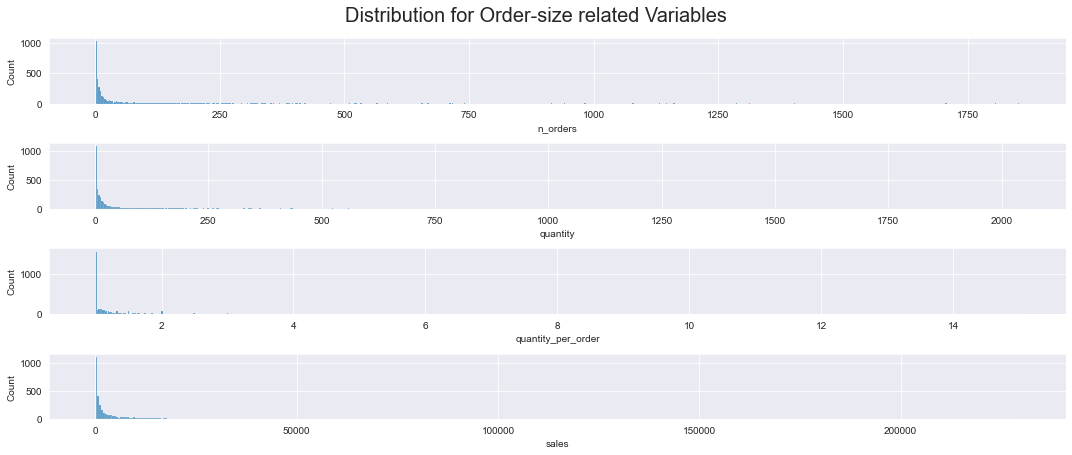

In [13]:
fig, (ax1, ax2, ax3, ax2) = plt.subplots(4,1)
plt.figure(figsize=(15,6)).suptitle('Distribution for Order-size related Variables', fontsize=20)
plt.close(1)

#'n_orders'
ax1 = plt.subplot(411)
ax1 = sns.histplot(sellers.n_orders)
plt.tight_layout()

#'quantity'
ax2 = plt.subplot(412)
ax2 = sns.histplot(sellers.quantity)

#'quantity_per_order'
ax3 = plt.subplot(413)
ax3 = sns.histplot(sellers.quantity_per_order)

#'sales'
ax3 = plt.subplot(414)
ax3 = sns.histplot(sellers.sales)

plt.show();

The outliers are quite extreme with these features making the plots difficult to read. We'll re-plot them with an adjusted view that excludes outliers.

In [14]:
sellers[['n_orders', 'quantity', 'quantity_per_order', 'sales']].describe()

,n_orders,quantity,quantity_per_order,sales
count,2970.000000,2970.000000,2970.000000,2970.000000
mean,33.617508,38.085185,1.162150,4566.515906
std,107.133714,122.417269,0.443348,14185.211617
min,1.000000,1.000000,1.000000,6.500000
25%,2.000000,3.000000,1.000000,239.800000
50%,7.000000,8.000000,1.000000,893.500000
75%,23.000000,26.000000,1.152009,3586.022500
max,1854.000000,2039.000000,15.000000,229472.630000


In [15]:
# Outlier calculations (based on 1.5*IQR)

features = ['n_orders', 'quantity', 'quantity_per_order', 'sales']

max_xlim = []
q3_xlim = []

for f in features:
    q3 = np.quantile(sellers[f], .75, axis=0) 
    q1 = np.quantile(sellers[f], .25, axis=0) 
    iqr = q3-q1 
    outlier_x = 1.5*iqr
    max_xlim.append(outlier_x)
    q3_xlim.append(q3)

max_xlim

[31.5, 34.5, 0.22801383399209474, 5019.33375]

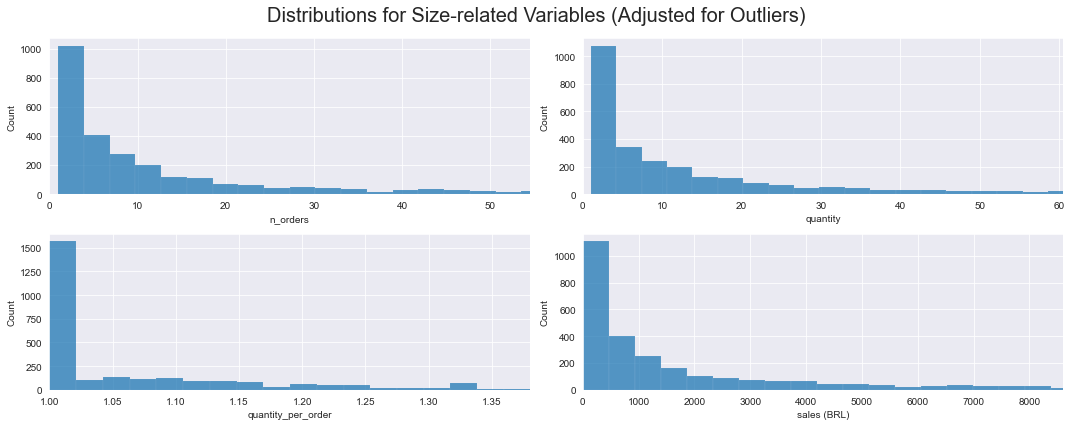

In [16]:
# Re-plotting features with an adjusted view to exclude outliers
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
plt.figure(figsize=(15,6)).suptitle('Distributions for Size-related Variables (Adjusted for Outliers)', fontsize=20)
plt.close(1)

#'n_orders'
ax1 = plt.subplot(221)
ax1 = sns.histplot(sellers.n_orders)
ax1.set_xlim(0, q3_xlim[0] + max_xlim[0])

#'quantity'
ax2 = plt.subplot(222)
ax2 = sns.histplot(sellers.quantity)
ax2.set_xlim(0, q3_xlim[1] + max_xlim[1])

#'quantity_per_order'
ax3 = plt.subplot(223)
ax3 = sns.histplot(sellers.quantity_per_order)
ax3.set_xlim(1, q3_xlim[2] + max_xlim[2])

#'sales'
ax4 = plt.subplot(224)
ax4 = sns.histplot(sellers.sales)
ax4.set_xlabel('sales (BRL)')
ax4.set_xlim(0, q3_xlim[3] + max_xlim[3])

plt.tight_layout()
plt.show();

Since both `n_orders` and `quantity` speak to the volume of product that sellers have sold, it's not surprising that their distribution is similar. If we think seller experience in processing orders is a factor associated with review scores, `n_orders` might be one feature that captures this.

With median `n_orders` of only **7**, we can see that most sellers on the platform have only had a few transactions. We'll see in our regression model, if this feature is helpful in explaining review scores.
 
The distribution of `quantity_per_order` indicates that most orders deal with a single item. If each order had multiple items, then we might consider that mix-ups in orders could be a factor contributing to low review scores, but here we see a low occurrence of multiple-item orders.  

The total `sales` per seller seems to follow a similar distribution with these other features—a heavy right skew, but with the bulk on the low end. Half of all sellers have generated less than **893.50 BRL** (~170 USD) in sales.

Another feature that might speak more directly to the experience of the seller is `months_on_olist`, which tells how long a seller has been on the platform.

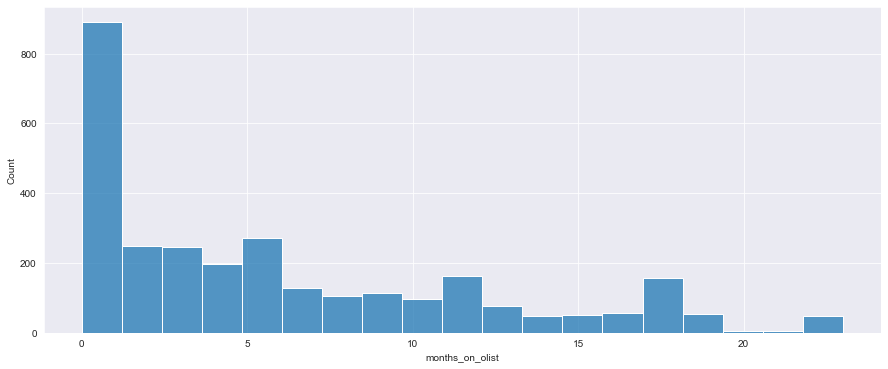

In [17]:
# 'months_on_olist' histogram
plt.figure(figsize=(15,6))
sns.histplot(sellers.months_on_olist)
plt.show()           

In [18]:
# Summary stats 
sellers[['months_on_olist']].describe()

,months_on_olist
count,2970.000000
mean,6.019529
std,5.994240
min,0.000000
25%,1.000000
50%,4.000000
75%,10.000000
max,23.000000


As a fairly new platform, we can see that the oldest sellers have been using Olist for only **23 months**. And, half of all sellers have only been using the platform for **4 months or less**. 

### Distribution of `seller_review_score`, `share_of_one_stars`, `share_of_five_stars`

These features indicate how sellers have been performing based on customer feedback.   

- `seller_review_score`: the average score of a seller's reviews 
- `share_of_one_stars`: the proportion of a seller's reviews with only one star 
- `share_of_five_stars`: the proportion of a seller's reviews with fives stars


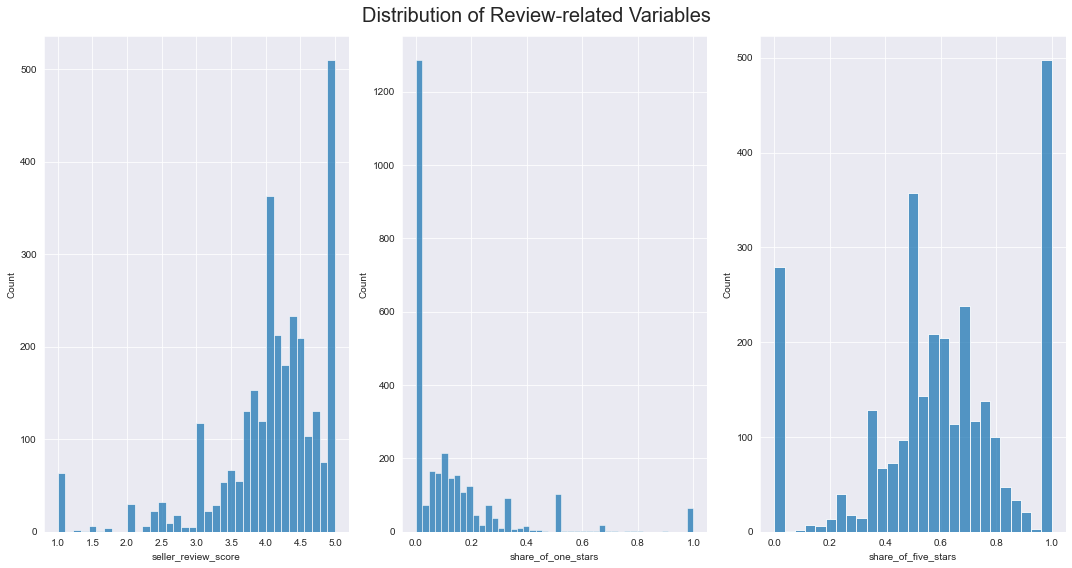

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
plt.close(1)
plt.figure(figsize=(15,8)).suptitle('Distribution of Review-related Variables', fontsize=20)

#'seller_review_score'
ax1 = plt.subplot(131)
ax1 = sns.histplot(sellers.seller_review_score)

#'share_of_one_stars'
ax2 = plt.subplot(132)
ax2 = sns.histplot(sellers.share_of_one_stars)

#'share_of_five_stars'
ax3 = plt.subplot(133)
ax3 = sns.histplot(sellers.share_of_five_stars)

plt.tight_layout()
plt.show();

In [20]:
sellers[['seller_review_score', 'share_of_one_stars', 'share_of_five_stars']].describe()

,seller_review_score,share_of_one_stars,share_of_five_stars
count,2970.000000,2970.000000,2970.000000
mean,4.086880,0.124570,0.592130
std,0.810166,0.191870,0.279057
min,1.000000,0.000000,0.000000
25%,3.818424,0.000000,0.478261
50%,4.200000,0.063856,0.600000
75%,4.625000,0.166667,0.750000
max,5.000000,1.000000,1.000000


From our histograms and statistical summary, we can see that the average `seller_review_score` is **close to 4** (mean=4.087), while those receiving an average score of **3.8 or less** already fall into the bottom 25% of seller performance (Q1=3.82). This reflects a **J-shaped distribution** which is a common phenomenon among online reviews and discussed earlier in our Orders dataset analysis. 

Examining the feature `share_of_one_stars`, we see that for **75% of all sellers** on the platform, a 1-star rating comprises only **a sixth or less** of their total reviews (Q3=0.167). For the remaining **25% of sellers**, who receive a larger proportion of 1-star reviews, we might want to scrutinize their performance further.

With `share_of_five_stars` we see a **W-shaped distribution** with three peaks. On the far right, there is a large number of 'super-performers' who have only ever received a 5-star review. Next, we have two smaller peaks occurring at a) the center, where only half of their reviews received a 'superb' 5-star review, and b) the far left, where a substantial number have never gotten 5 stars. 

For a fairer assessment that takes into consideration the total number of reviews each seller has received, we could explore assigning weights to each 1-star (or 5-star review) that are proportional to the total number of reviews received (i.e. we could control that a seller with a hundred 5-star reviews and a single 1-star review would still rank higher than a seller with only ten reviews but all of which are 5-star).        

## Correlations

Let's check out the correlations between different features in the Sellers dataset

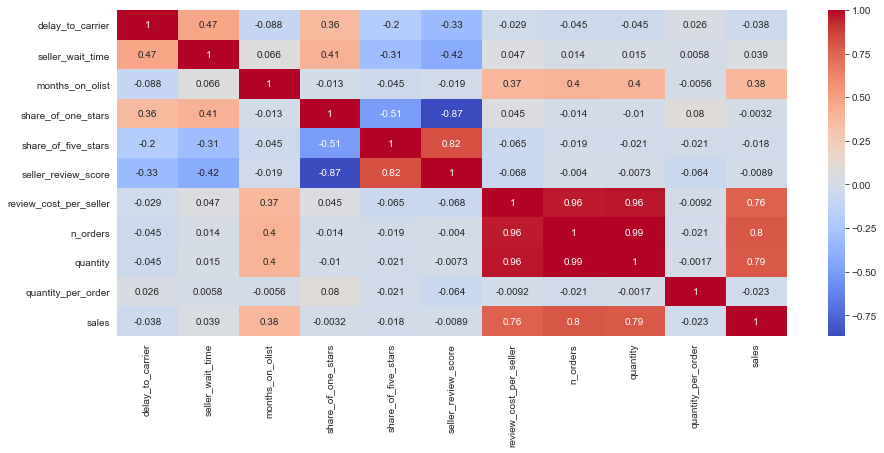

In [21]:
plt.figure(figsize=(15,6))
sns.heatmap(sellers.corr(), cmap='coolwarm', annot=True );

In [22]:
sellers.corr()['seller_review_score']

delay_to_carrier         -0.325642
seller_wait_time         -0.419605
months_on_olist          -0.018910
share_of_one_stars       -0.869186
share_of_five_stars       0.818685
seller_review_score       1.000000
review_cost_per_seller   -0.067521
n_orders                 -0.003983
quantity                 -0.007311
quantity_per_order       -0.064025
sales                    -0.008910
Name: seller_review_score, dtype: float64

Among features that aren't derived from `seller_review_score`, those that capture delivery time such as `delay_to_carrier` (r=-0.33) and `seller_wait_time` (r=-0.42) have the largest correlation with `seller_review_score`. This is similar to our findings in the Orders dataset. 

In addition, since `seller_wait_time` includes the time a seller ships to the carrier, it also makes sense that this feature is also correlated with `delay_to_carrier` (r=0.47).

## Multivariate Regression  

We'll now run a multivariate regression model with select features from the Sellers dataset to better understand their impact on `seller_review_score`. 

### Feature Scaling

To make sure we'll be able to compare the coefficents for features in different units, we'll first do some feature scaling. Since many of the features have outliers, we'll use the standardization approach over normalization
since standardization does not scale the features based on the range of values. 

In [23]:
# Apply feature scaling 

def standardize(df, features): 
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized


### Linear Regression | Base Model

Let's now select features and run a multivariate linear regression model to determine how much each feature impacts `seller_review_score`.

In [24]:
features = ['delay_to_carrier', 'seller_wait_time', 'months_on_olist', 'n_orders', 'quantity', 'quantity_per_order', 'sales']
sellers_standardized = standardize(sellers, features)
model = smf.ols(formula=f"seller_review_score ~ {'+ '.join(features)}", data=sellers_standardized).fit()

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     seller_review_score   R-squared:                       0.201
Model:                             OLS   Adj. R-squared:                  0.199
Method:                  Least Squares   F-statistic:                     106.3
Date:                 Fri, 03 Sep 2021   Prob (F-statistic):          3.41e-139
Time:                         13:05:51   Log-Likelihood:                -3255.7
No. Observations:                 2970   AIC:                             6527.
Df Residuals:                     2962   BIC:                             6575.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.0869      0.013    307.146      0.000       4.061       4.113
delay_to_carrier      -0.1329      0.015     -8.718      0.000      -0.163      -0.103
seller_wait_time      -0.2764      0.015    -18.152      0.000      -0.306      -0.247
months_on_olist       -0.0086      0.015     -0.582      0.561      -0.038       0.020
n_orders               0.1054      0.118      0.889      0.374      -0.127       0.338
quantity              -0.1162      0.117     -0.991      0.322      -0.346       0.114
quantity_per_order    -0.0446      0.014     -3.307      0.001      -0.071      -0.018
sales                  0.0089      0.022      0.400      0.689      -0.035       0.053
==============================================================================
Omnibus:                      814.846   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2778.042
Skew:                          -1.353   Prob(JB):                         0.00
Kurtosis:                       6.890   Cond. No.                         21.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation of Results**

- This model has a low **R-squared** (0.20) suggesting that the currently selected features only explain **20% of the variance** found in the review scores. Also, the lower value for **Adj. R-squared** (0.199) suggests that we may have extra features in our model that are contributing more to noise than to what factors influence our target variable. 
- The **f-proba** shows that our **R-squared** is **statistically significant** and that it performs better than a model without any features.
- The coefficients for the features `months_on_olist`, `n_orders`, `quantity`, and `sales` are **not statistically significant** as their **p-values** are **not less than our chosen alpha of 0.05**. 
- Additionally, we see that a value of 0 falls within the **95% confidence interval** for these features. Since a zero coefficient would mean that the feature has no influence on the target variable (i.e. our null hypothesis), this would mean we can't reject the null hypothesis and that that the given **coefficients** for these features are **not reliable**. 

Now let's remove the non-reliable features and run another regression model.

### Linear Regression | Revised Model

In [26]:
# Revised feature selection
revised_features = ['delay_to_carrier', 'seller_wait_time', 'quantity_per_order']
sellers_standardized = standardize(sellers, revised_features)
revised_model = smf.ols(formula=f"seller_review_score ~ {'+ '.join(revised_features)}", data=sellers_standardized).fit()

In [27]:
revised_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     seller_review_score   R-squared:                       0.200
Model:                             OLS   Adj. R-squared:                  0.200
Method:                  Least Squares   F-statistic:                     247.7
Date:                 Fri, 03 Sep 2021   Prob (F-statistic):          2.08e-143
Time:                         13:05:51   Log-Likelihood:                -3256.6
No. Observations:                 2970   AIC:                             6521.
Df Residuals:                     2966   BIC:                             6545.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.0869      0.013    307.268      0.000       4.061       4.113
delay_to_carrier      -0.1315      0.015     -8.710      0.000      -0.161      -0.102
seller_wait_time      -0.2776      0.015    -18.391      0.000      -0.307      -0.248
quantity_per_order    -0.0468      0.013     -3.519      0.000      -0.073      -0.021
==============================================================================
Omnibus:                      797.448   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2693.675
Skew:                          -1.326   Prob(JB):                         0.00
Kurtosis:                       6.838   Cond. No.                         1.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation of Results**

- With this reduced set of features, our model is still only able to explain about **20% of the variance** in the seller review scores (R2=0.20). 


In [28]:
revised_model.params

Intercept             4.086880
delay_to_carrier     -0.131504
seller_wait_time     -0.277566
quantity_per_order   -0.046824
dtype: float64

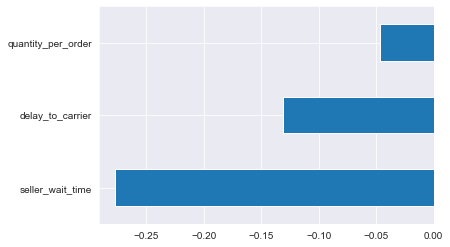

In [29]:
revised_model.params[1:].sort_values().plot(kind='barh');

### Residuals and RMSE

Let's look at the **residuals** (predicted values - real values) and calculate the **Root Mean Square Error (RMSE)** as a check on well our multivariate regression model is performing. 

In [30]:
# Calculate residuals (predicted values - real values)
predicted_review_score = revised_model.predict(sellers_standardized[features])
residuals = predicted_review_score - sellers_standardized.seller_review_score
residuals.head()

0    1.092618
1   -0.305559
2   -0.556623
3   -0.620117
4    2.036966
dtype: float64

In [31]:
# Calculate the RMSE
RMSE = (residuals.map(lambda x: x**2).sum() / len(residuals))**0.5
RMSE

0.7243697584549219

The **RMSE** tells us that on average our predicted scores are **0.7** stars off of the real scores. On a 5-star rating system, that's not too bad. 

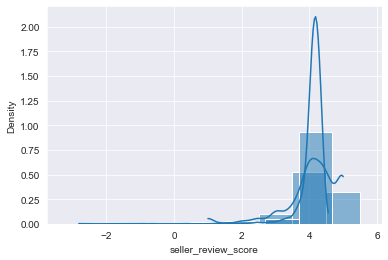

In [32]:
sns.histplot(sellers['seller_review_score'], kde=True, stat='density', discrete=True)
sns.histplot(revised_model.predict(sellers_standardized[features]), kde=True, stat='density', discrete=True);


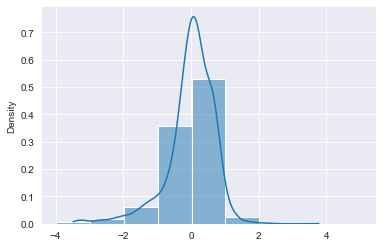

In [33]:
sns.histplot(model.resid, kde=True, stat='density', discrete=True);

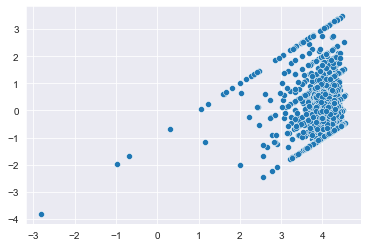

In [34]:
# Let's check the variance by plotting the residuals against the fitted values
sns.scatterplot(y=residuals, x=predicted_review_score);

 ## Logistic Regression

Since the `seller_review_score` is calculated as an average for each seller, we can get a continuous target variable ranging from 0-5 stars. This differs from the Orders dataset feature of `review_score` which could be understood as a ordinal categorical variable. This perhaps explains a slightly better **R-squared of = 0.20** for our **Sellers Linear Regression** compared to the one from our **Orders Linear Regression (R2 = 0.14)**.

Like we did for the **Orders dataset**, let's try running logistic regression models for both **1-star** (`share_of_one_stars`) and **5-star** (`share_of_five_stars`) **reviews**, but for our **Sellers dataset**.

### Check for Multicollinearity with VIF

We'll use our revised set of features, standardize them, and then check for multi-collinearity (i.e. high correlation between features) by looking at the **variance inflation factor (VIF)**.

In [57]:
revised_features = ['delay_to_carrier', 'seller_wait_time', 'quantity_per_order']

X = sellers[revised_features]
X.head()

,delay_to_carrier,seller_wait_time,quantity_per_order
0,0.000000,13.018588,1.000
1,0.000000,9.065716,1.025
2,0.000000,4.042292,1.000
3,0.000000,5.667187,1.000
4,3.353727,35.314861,1.000


In [58]:
df = pd.DataFrame()
df['VIF'] = [vif(X.values, i) for i in range(X.shape[1])]
df['Features'] = X.columns
df

,VIF,Features
0,1.250906,delay_to_carrier
1,3.503983,seller_wait_time
2,3.085841,quantity_per_order


The **VIF** tells us how much the variance in an estimated coefficient is inflated due to multi-collinearity. For example, the variance for the estimated coefficient of our feature `seller_wait_time` is inflated by a factor of **3.5**. Generally, we can accept VIF values below 10.

### Logistic Regression | 1-Star Review Model

Now let's run our logistic regression model for 1-star reviews  

In [37]:
#Fit logit model for 1-star reviews
sellers_standardized = standardize(sellers, revised_features)
logit_one = smf.logit(formula=f"share_of_one_stars ~ {'+ '.join(revised_features)}", data=sellers_standardized).fit()
logit_one.summary()

Optimization terminated successfully.
         Current function value: 0.232556
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     share_of_one_stars   No. Observations:                 2970
Model:                          Logit   Df Residuals:                     2966
Method:                           MLE   Df Model:                            3
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                 -0.2908
Time:                        13:05:53   Log-Likelihood:                -690.69
converged:                       True   LL-Null:                       -535.09
Covariance Type:            nonrobust   LLR p-value:                     1.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.0497      0.060    -34.373      0.000      -2.167      -1.933
delay_to_carrier       0.1927      0.063      3.071      0.002       0.070       0.316
seller_wait_time       0.5206      0.066      7.943      0.000       0.392       0.649
quantity_per_order     0.0971      0.048      2.036      0.042       0.004       0.191
======================================================================================
"""

To better interpret the coefficients from our logistic regression model, we'll convert units from log-odds (logits) to odds. 

In [38]:
# Log-odds to odds conversion by exponentiating
logit_one_results = pd.DataFrame(logit_one.params, columns=['log-odds'])
logit_one_results['odds'] = logit_one_results['log-odds'].apply(lambda x: math.exp(x))
logit_one_results

,log-odds,odds
Intercept,-2.049681,0.128776
delay_to_carrier,0.192672,1.212484
seller_wait_time,0.520643,1.683109
quantity_per_order,0.097100,1.101970


All of our coefficients are **statistically significant** given our **p-values** are below are alpha of 0.05. However, we note that the feature `quantity_per_order` is quite close to threshold (p-value = 0.042) 

With our model, we see that `seller_wait_time` has the most influence on receiving a 1-star review.

*Holding all other variables constant, for each additional day in `seller_wait_time`, on average there is a **68% increase in odds** of getting a 1-star review*.

### Logistic Regression | 5-Star Review Model

Now let's run another logistic regression model for 5-star reviews.  

In [62]:
#Fit logit model for 5-star reviews
sellers_standardized = standardize(sellers, revised_features)
logit_five = smf.logit(formula=f"share_of_five_stars ~ {'+ '.join(revised_features)}", data=sellers_standardized).fit()
logit_five.summary()

Optimization terminated successfully.
         Current function value: 0.636639
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     share_of_five_stars   No. Observations:                 2970
Model:                           Logit   Df Residuals:                     2966
Method:                            MLE   Df Model:                            3
Date:                 Fri, 03 Sep 2021   Pseudo R-squ.:                0.008160
Time:                         14:53:43   Log-Likelihood:                -1890.8
converged:                        True   LL-Null:                       -1906.4
Covariance Type:             nonrobust   LLR p-value:                 8.045e-07
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3676      0.038      9.622      0.000       0.293       0.442
delay_to_carrier      -0.1321      0.067     -1.982      0.047      -0.263      -0.001
seller_wait_time      -0.4206      0.054     -7.741      0.000      -0.527      -0.314
quantity_per_order    -0.0197      0.038     -0.519      0.604      -0.094       0.055
======================================================================================
"""

In [40]:
# Log-odds to odds conversion by exponentiating
logit_five_results = pd.DataFrame(logit_five.params, columns=['log-odds'])
logit_five_results['odds'] = logit_five_results['log-odds'].apply(lambda x: math.exp(x))
logit_five_results

,log-odds,odds
Intercept,0.367579,1.444234
delay_to_carrier,-0.132075,0.876275
seller_wait_time,-0.420552,0.656684
quantity_per_order,-0.019682,0.980510


In this model, our feature `quantity_per_order` is **not statistically significant** (p-value = 0.60), and we cannot reject the null hypothesis that `quantity_per_order` has no impact on receiving a 5-star. While the coefficients for our other two features are **statistically significant**, we note that the p-value for `delay_to_carrier` (p-value = 0.047) is close to our alpha threshold of 0.05).  

With this model, we also see `seller_wait_time` as have the largest influence on the star rating.

*Holding all other variables constant, for each additional day in `seller_wait_time`, on average there is a **34% decrease in odds** of getting a 5-star review.*

### Logistic Regression Model Comparison

<Figure size 432x288 with 0 Axes>

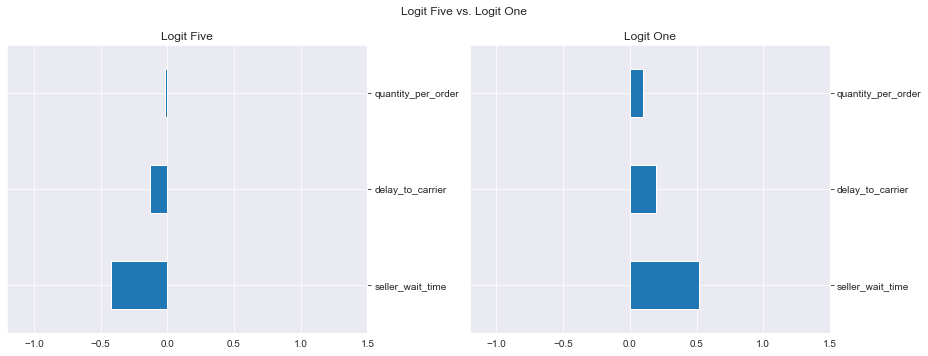

In [48]:
# Logistic Regression Model Comparison
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
fig.suptitle('Logit Five vs. Logit One')

# Logistic Regression - logit_five_model
ax1 = plt.subplot(1,2,1)
ax1.set_title('Logit Five')
ax1.yaxis.tick_right()
ax1.set_xlim(-1.2, 1.5)
logit_five.params[1:].sort_values().plot(kind='barh', ax=ax1)

# Logistic Regression - logit_one_model
ax2 = plt.subplot(1,2,2)
ax2.set_title('Logit One')
ax2.yaxis.tick_right()
ax2.set_xlim(-1.2, 1.5)
logit_one.params[1:].sort_values(ascending=False).plot(kind='barh', ax=ax2)

plt.tight_layout()
plt.show();

Both our logistic regression models seem to point to `seller_wait_time` as the most influential feature in receiving a 1- or 5-star review.  

### Linear vs Logistic Regression Coefficients

Let's plot and compare the coefficients of both our linear regression and logistic regression models to see if they are generally telling the same story. 

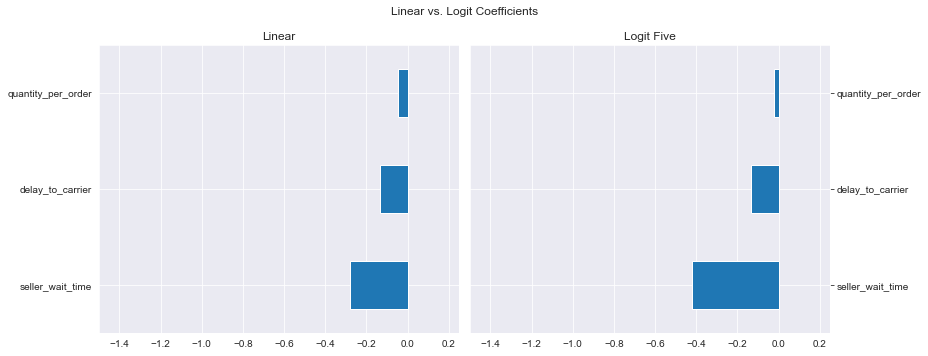

In [42]:
plt.figure(figsize=(13,5))
plt.suptitle('Linear vs. Logit Coefficients')

# Linear Regression - model4
ax1 = plt.subplot(1,2,1)
ax1.set_title('Linear')
ax1.set_xlim(-1.5, 0.25)
revised_model.params[1:].sort_values().plot(kind='barh', ax=ax1)

# Logistic Regression - logit_five_model
ax2 = plt.subplot(1,2,2)
ax2.set_title('Logit Five')
ax2.yaxis.tick_right()
ax2.set_xlim(-1.5, 0.25)
logit_five.params[1:].sort_values().plot(kind='barh', ax=ax2)

plt.tight_layout()
plt.show()

With our Sellers data, we see similar feature importance between the linear and logistic regression models. `Seller_wait_time` appears to have the largest influence in the review score that sellers receive. 